In [14]:
import requests
import json
import pandas as pd
from bls_definitions import bls_ppi_codes

In [2]:
key = "9648e84bbf0f4c38b01689279269a05e"
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
startyear = ""
endyear = ""

In [3]:
data = json.dumps({"seriesid": ['WPSFD4', 'WPUFD4'], "startyear":startyear, "endyear":endyear, "registrationkey" : key})

In [4]:
data

'{"seriesid": ["WPSFD4", "WPUFD4"], "startyear": "", "endyear": "", "registrationkey": "9648e84bbf0f4c38b01689279269a05e"}'

In [5]:
headers = {'Content-type' : 'application/json'}

In [6]:
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)

In [7]:
p.json()

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 239,
 'message': [],
 'Results': {'series': [{'seriesID': 'WPSFD4',
    'data': [{'year': '2023',
      'period': 'M02',
      'periodName': 'February',
      'latest': 'true',
      'value': '141.078',
      'footnotes': [{'code': 'P',
        'text': 'Preliminary. All indexes are subject to monthly revisions up to four months after original publication.'}]},
     {'year': '2023',
      'period': 'M01',
      'periodName': 'January',
      'value': '141.284',
      'footnotes': [{'code': 'P',
        'text': 'Preliminary. All indexes are subject to monthly revisions up to four months after original publication.'}]},
     {'year': '2022',
      'period': 'M12',
      'periodName': 'December',
      'value': '140.800',
      'footnotes': [{'code': 'P',
        'text': 'Preliminary. All indexes are subject to monthly revisions up to four months after original publication.'}]},
     {'year': '2022',
      'period': 'M11',
      'periodName'

In [8]:
p = p.json()['Results']['series']

In [9]:
date_list = [f"{i['year']}-{i['period'][1:]}-01" for i in p[0]['data']]

In [10]:
df = pd.DataFrame(index = pd.to_datetime(date_list[::-1]))

In [11]:
for i in p:
    df[i['seriesID']] = pd.Series([j['value'] for j in i['data']]).astype(float).iloc[::-1].values


<AxesSubplot:>

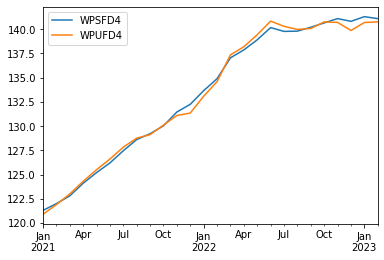

In [12]:
df.plot()

In [13]:
df

,WPSFD4,WPUFD4
2021-01-01,121.300,120.900
2021-02-01,122.000,121.900
2021-03-01,122.800,123.000
2021-04-01,124.100,124.300
2021-05-01,125.200,125.500
2021-06-01,126.200,126.600
2021-07-01,127.453,127.824
2021-08-01,128.610,128.755
2021-09-01,129.210,129.116
2021-10-01,130.027,130.097
